In [6]:
## Implementing K-nearest neighbours algorithm from scratch
# This model is a lazy one that basically just stores the data points of the training data
# then for new data predicts the class of the highnest number from its k (arbitrary number that is chosen) closest data points
# Euclidean distance would be used to measure the closeness of data points

import numpy as np

class KNN:
  def __init__(self, k = 3): # Setting 3 as the default value for k
    self.k = k # K is the number of nearest meighbours to consider

  def fit(self, X, y): # Fitting the model to the triain data set
    # Fitting is basically just storing the values in the training data
    self.X = X
    self.y = y

  def euclidean_distance(self, x1, x2): # Function to measure closeness
    return np.sqrt(np.sum((x1 - x2)) ** 2)

  def predict(self, x):
    """
      Predict the value for a single data point, x:
      1. compute the euclidean distance from all the training data
      2. find the k nearest neighbours
      3. predict the class of the mode of the k nearest neighbours
    """
    distances = [self.euclidean_distance(x, X) for X in self.X]
    k_neighbours = np.argsort(distances)[:self.k]
    labels = [self.y[i] for i in k_neighbours]
    dct = {}
    for label in labels: # using a dictionary to count number of occurence
      if label in dct.keys():
        dct[label]+=1
      else:
        dct[label] = 1
    return  max(dct, key = dct.get)## predicting the most ocuring neighbour


In [9]:
# Testing model with synthetic dataset

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Generate a simple binary classification dataset
X, y = make_classification(
    n_samples=200, n_features=2, n_informative=2, n_redundant=0,
    n_clusters_per_class=1, random_state=42
)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train KNN model
model = KNN(k=7)
model.fit(X_train, y_train)

# Make Predictions
predictions = [model.predict(X_data) for X_data in X_test ]

# Evaluate accuracy
acc = accuracy_score(y_test, predictions)
print(f"KNN Accuracy: {acc:.2f}")

KNN Accuracy: 0.82


In [16]:
## Hmm not bad
## Now i would implement cross validation for tuning k

import matplotlib.pyplot as plt


def kfold_cv (X, y, k_values = [3,5,7,9], folds = 5):
  n_samples = len(X)
  indices = np.arange(n_samples)
  np.random.shuffle(indices) # Shuffle before split
  fold_sizes = n_samples // folds # Getting the size of data per fold

  best_k = None
  best_score = 0
  score_dct = {}

  for k in k_values:
    fold_accuracies = []

    for fold in range(folds):
      # Tracking our progress through the folds
      start = fold * fold_sizes
      end = (fold + 1) * fold_sizes if fold != folds - 1 else n_samples

      # Validation set
      val_idx = indices[start:end]
      X_val, y_val = X[val_idx], y[val_idx]

      # The rest would be the trainset
      train_idx = np.concatenate((indices[:start], indices[end:]))
      X_train, y_train = X[train_idx], y[train_idx]

      # Training and validation
      model = KNN(k = k)
      model.fit(X_train, y_train)
      y_pred = [model.predict(X_data) for X_data in X_val]
      acc = accuracy_score(y_val, y_pred)
      # Store accuracy
      fold_accuracies.append(acc)

    #Calculate average accuracy add to dictionary
    avg_acc = np.mean(fold_accuracies)
    score_dct[k] = avg_acc

    # Update the best accuracy
    if best_score < avg_acc:
      best_score = avg_acc
      best_k = k


  return best_k, best_score, score_dct


def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.02),
        np.arange(y_min, y_max, 0.02)
    )

    # Predict over grid
    Z = [model.predict(sample) for sample in np.c_[xx.ravel(), yy.ravel()]]
    Z = np.array(Z).reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", marker="o")
    plt.title(f"KNN Decision Boundary (k={model.k})")
    plt.show()


Cross-validation results:
k=3, Avg CV Accuracy=0.688
k=5, Avg CV Accuracy=0.688
k=7, Avg CV Accuracy=0.713
k=9, Avg CV Accuracy=0.725

Best k: 9 with CV Accuracy: 0.725
Test Accuracy with k=9: 0.775


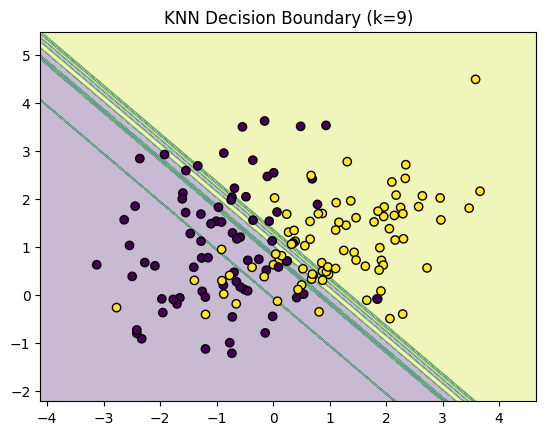

In [19]:
best_k, best_scores, scores_dictionary = kfold_cv(X_train, y_train)

print("Cross-validation results:")
for k, score in scores_dictionary.items():
    print(f"k={k}, Avg CV Accuracy={score:.3f}")

print(f"\nBest k: {best_k} with CV Accuracy: {best_scores:.3f}")

# Train final model
best_model = KNN(k=best_k)
best_model.fit(X_train, y_train)
y_pred = [best_model.predict(X_data) for X_data in X_test ]

test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy with k={best_k}: {test_acc:.3f}")

# Plot decision boundary
plot_decision_boundary(best_model, X_train, y_train)